# Random Synthethic Tests of Focusing Neuron.

##  This notebook is prepared for "Adaptive Locally Connected Neuron: Focusing Neuron" paper by F. Boray TEK


**This notebook, tests Focusing Neuron against Fully Connected Neuron in synthethized data
It repeatedly creates synthetic datasets, different networks and training paramaters and compares validation accuracy reached at a certain epoch value.**


 * Focusing Network Test Case for Synthetic data sets
 * The network here is very simple two layer network and for demonstration only
 * To obtain large scale tests of the paper refer to mnist.py
 * If running on GOOGLE COLAB, change Runtime type to GPU
 * Requires, focusing.py, data_utils.py, lasagne_utils.py, 
 * ----< If running on GOOGLE COLAB, upload focusing.py, data_utils.py, lasagne_utils.py, plot_utils >----
 


* Code Authors:  F. Boray Tek (İlker Çam contributed to an earlier version)
 
 * For details, see the paper:
 * 
 *  http://arxiv.org/abs/1809.09533
 * 
 *
 * Permission to use, copy, modify, and distribute this software and
 * its documentation for educational, research, and non-commercial
 * purposes, without fee and without a signed licensing agreement, is
 * hereby granted, provided that the above copyright notice and this
 * paragraph appear in all copies modifications, and distributions.
 *
 * NOTE: THIS WORK IS PATENT PENDING!
 * Patent rights are owned by F. Boray Tek, İlker Çam, Işık University
 * Any commercial use or any commercial redistribution of this software
 * requires a license from one of the above mentioned establishments.

 * For further details, contact F. Boray Tek (boraytek@gmail.com).

In [0]:
#@markdown ### INSTALL THEANO AND LASAGNE BY UNCOMMENTING THESE LINES
#!pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
#!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip

In [1]:
#@markdown ### IMPORTS, DO NOT FORGET UPLOAD focusing.py, lasagne_utils.oy, data_utils.py

import os
os.environ['THEANO_FLAGS']='device=cuda,floatX=float32,preallocate=0.1'
os.environ['MKL_THREADING_LAYER']='GNU'
import time
import matplotlib.pyplot as plt
import lasagne
import theano
theano.config.exception_verbosity = 'high'
import theano.tensor as T
import numpy as np
from focusing import FocusedLayer1D
from collections import OrderedDict
from lasagne.updates import get_or_compute_grads, apply_momentum, sgd
from lasagne.updates import momentum, adam, adadelta
from lasagne.regularization import regularize_layer_params_weighted, l2, l1
from lasagne.regularization import regularize_layer_params

#from plot_utils import save_fig, paper_fig_settings

from lasagne_utils import sgdWithLrsClip,categorical_focal_loss,\
get_shared_by_pattern,sgdWithLrs,iterate_minibatches,set_params_value,\
print_param_stats, get_params_values_wkey,sgdWithWeightSupress

import pandas as pd
#pandas.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)[source]¶
from data_utils import load_blob

/usr/local/lib/python3.6/dist-packages/theano/configdefaults.py:1952: UserWarning: Theano does not recognise this flag: preallocate
  warnings.warn('Theano does not recognise this flag: {0}'.format(key))
ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


In [0]:
#@markdown ### SETTINGS FOR FIGURES
%matplotlib inline
import matplotlib
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

In [0]:
#@markdown ## MODEL BUILDING &TRAINING FUNCTIONS
def build_dense_model(input_feas, fparams):
    # Initers, Layers
    nhidden = fparams['nHIDDEN']
    nclasses = fparams['nCLASSES']
    batchnorm = fparams['USEBATCHNORM']
    use_penalty = fparams['USE_PENALTY']
    ini = lasagne.init.GlorotUniform()
    
    nonlin = lasagne.nonlinearities.rectify
    softmax = lasagne.nonlinearities.softmax
    
    lin = lasagne.nonlinearities.linear
    
    # Input Layer
    l_in = lasagne.layers.InputLayer(shape=(None, input_feas))
    
    # Denses
    l_dense1 = lasagne.layers.DenseLayer(
            l_in, num_units=nhidden, 
            nonlinearity=lin, 
            W=ini, name="dense1")
    
    
    if batchnorm:
    # if you close BATCHNORM weights get LARGE
        l_bn = lasagne.layers.NonlinearityLayer(
                lasagne.layers.BatchNormLayer(l_dense1), nonlinearity=nonlin)
    
    else:
    
        l_bn = lasagne.layers.NonlinearityLayer(l_dense1, nonlinearity=nonlin)
    #l_dense2 = lasagne.layers.DenseLayer(l_dense1, num_units=4, nonlinearity=lasagne.nonlinearities.tanh, W=ini, name='dense2')
    
    #l_drop1 = lasagne.layers.dropout(l_bn, p=0.1)
    
    # Output Layer
    l_out = lasagne.layers.DenseLayer(l_bn, num_units=nclasses, nonlinearity=softmax, W=ini, name='output')
    
    
    penalty = (l2(l_dense1.W)*1e-4)+(l1(l_dense1.W)*1e-6) +(l2(l_out.W)*1e-3)
    if not use_penalty:
        penalty = penalty*0
    
    #penalty = penalty*0
    #penalty = (l2(l_dense1.W)*1e-30)#(l2(l_dense1.W)*1e-3)+(l1(l_dense1.W)*1e-6) +(l2(l_out.W)*1e-3)
    
    return l_out, penalty

In [0]:
def build_focused_model(input_feas, fparams):
    # Initers, Layers
    
    nhidden = fparams['nHIDDEN']
    nclasses = fparams['nCLASSES']
    batchnorm = fparams['USEBATCHNORM']
    use_penalty = fparams['USE_PENALTY']
    
    ini = lasagne.init.GlorotUniform()
    nonlin = lasagne.nonlinearities.rectify
    linear = lasagne.nonlinearities.linear
    softmax = lasagne.nonlinearities.softmax

    
    # Input Layer
    
    l_in = lasagne.layers.InputLayer(shape=(None, input_feas))
    
    l_focus1 = FocusedLayer1D(l_in, num_units=nhidden, 
                              nonlinearity=linear, name='focus1',
                              trainMus=fparams['trainMus'],
                              trainSis=fparams['trainSis'],
                              initMu=fparams['initMu'], 
                              W=ini, withWeights=fparams['withWeights'], 
                              bias=lasagne.init.Constant(0.0), 
                              initSigma=fparams['initSigma'], 
                              trainWs=fparams['trainWs'])
                                               
    
    if batchnorm:
    # if you close BATCHNORM weights get LARGE
        l_bn = lasagne.layers.NonlinearityLayer(
                lasagne.layers.BatchNormLayer(l_focus1), nonlinearity=nonlin)
    
    else:
    
        l_bn = lasagne.layers.NonlinearityLayer(l_focus1, nonlinearity=nonlin)
 
    #l_drop1 = lasagne.layers.dropout(l_bn, p=0.1)
    
    # Output
    l_out = lasagne.layers.DenseLayer(l_bn, num_units=nclasses, 
                                      nonlinearity=softmax, W=ini, name='output')
    
    penalty = l2(l_out.W)*np.float32(1e-3)
    # if focusing neuron has weights. add penalty to them as well. A 10th factors less because focus function already suppresses weghts
    if fparams['withWeights']:
        penalty += l2(l_focus1.W)**np.float32(1e-4)
    
    if not use_penalty:
        penalty = penalty*0
    
    
    return l_out, penalty

In [0]:
# Compile train and eval functions
def build_functions(using_model, fparams, penalty):
    X = T.fmatrix()
    y = T.ivector()

    # training output
    output_train = lasagne.layers.get_output(using_model, X, deterministic=False)

    # evaluation output. Also includes output of transform for plotting
    output_eval = lasagne.layers.get_output(using_model, X, deterministic=True)
    
    cost = T.mean(lasagne.objectives.categorical_crossentropy(output_train, y)) + penalty # Regularization
  
    network_params = lasagne.layers.get_all_params(using_model, trainable=True)
    print("Params",network_params)
    n_params =  lasagne.layers.count_params(using_model)
    print("Param count:",n_params)
    
    LR_rate = theano.shared(np.float32(fparams['LEARNING_RATE']),name='lr_all')
    LR_MU = theano.shared(np.float32(fparams['LR_MU']),name='lr_mu')
    LR_SI = theano.shared(np.float32(fparams['LR_SI']),name='lr_si')
    LR_FW = theano.shared(np.float32(fparams['LR_FW']),name='lr_fw')
    LR_params = [LR_rate, LR_MU, LR_SI, LR_FW]
        
    updates = sgdWithLrsClip(cost, network_params, learning_rate=LR_rate, 
                         mu_lr=LR_MU, si_lr=LR_SI, 
                         focused_w_lr=LR_FW, momentum=fparams['MOMENTUM'])
    
    test_acc = T.mean(T.eq(T.argmax(output_eval, axis=1), y), dtype=theano.config.floatX)

    evalf = theano.function([X, y], [cost, output_eval, test_acc], allow_input_downcast=True, name='eval')
    trainf = theano.function([X, y], [cost, output_train, penalty], updates=updates, allow_input_downcast=True, name='train')
    
    return trainf, evalf, n_params

In [0]:
# Epoch tranining with mini-batch
def epoch_func(X, y, fnc, penalty=False, batch_size=512):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(batch_size)))
    costs = []
    correct = 0
    penalties = []
    for i in range(num_batches):
        idx = range(i*batch_size, np.minimum((i+1)*batch_size, num_samples))
        X_batch = X[idx]
        y_batch = y[idx]
        outputs = fnc(X_batch, y_batch)
        costs += [outputs[0]]
        probs = outputs[1]
        preds = np.argmax(probs, axis=-1)
        correct += np.sum(y_batch == preds)
        if fnc.name.startswith('train'):
            if penalty:
                penalties += [penalty]
                
    acc = correct/float(num_samples)
    pen = []
    if not penalties:
        pen = np.mean(penalties)
    
    return np.mean(costs), acc , pen 

## EXPERIMENT SETTINGS 

In [0]:
#@markdown ## EXPERIMENT SETTINGS (SAVES FIGURES WHEN RUN LOCALLY)
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "BILISIM/"
EXPERIMENT_ID = "ex-1"
RANDSEED = 42
#paper_fig_settings()

from  datetime import datetime
now = datetime.now()
timestr = now.strftime("%Y%m%d-%H%M%S")
logdir = path = os.path.join(PROJECT_ROOT_DIR, "outputs", 
                        CHAPTER_ID+EXPERIMENT_ID)


lasagne.random.set_rng(np.random.RandomState(RANDSEED))  # Set random state so we can investigate results
np.random.seed(RANDSEED)
np.set_printoptions(formatter={'float': '{: 0.4f}'.format}, suppress=True)

PLOT_INT_RESULTS = False
PRINT_INTERVAL = 10
RECORD_INTERVAL= 1

N_TEST_REPEATS = 250    # We will do this many experiments with random hyperparameters and problem parameters
N_RANDOM_REPEATS_FOR_SET = 3 # For each hyperparameter and problem set, we will repeat the experiment. 


In [8]:
#@markdown ## FOCUSING LAYERS SETTINGS

Fparams={}
Fparams['trainSis'] = True
Fparams['trainMus'] = True    
Fparams['trainWs'] = True
Fparams['withWeights'] = True
Fparams['initMu'] = 'spread'# 'middle' Or sth else
Fparams['initSigma'] = 0.15 # this works slightly better than 0.1 for this experiment
print(Fparams)

                              

{'trainSis': True, 'trainMus': True, 'trainWs': True, 'withWeights': True, 'initMu': 'spread', 'initSigma': 0.15}


In [0]:
#@markdown ## Hyper Parameter Test SETS


NUM_EPOCHS = 150

nSAMPLES = np.array([100,1000, 2000,10000])
BATCH_SIZE = [0.1,0.05]

USEBATCHNORM = [True,True] #False is 2x 3x times faster, and performance is worse

MOMENTUM = np.array(np.float32([.5])) # .9 may be worse
USE_PENALTY = [False]  # No significant difference perhaps due to low number of epochs
nCLASSES = np.array([2,4,8])
nFEATURES= np.array([4,40,100])
nCLUSTERS = np.array([1,2,4])



NOISE_DIMS = np.array([0, 0.5, 1]) # We add this many NOISE_DIMS*nFeatures to nFeatures
NOISE_SCALE = 1.0 # data is standard, this should not affect anything
NOISE_PATTERN= ['left','sides'] # position of the noise with respect to sampled dataset.
    
#LEARNING_RATE = np.float32([0.1,0.01,0.001]) #0.001 is too low for many datasets. 
LEARNING_RATE = np.float32([0.01]) # works good majority 
LR_SCALER = 0.01; 

nHIDDEN = [4,40,100]


# this method chooses random values from a list of arrays
def choose_rand(x):
    val=[]
    for k in range(len(x)):
        v = np.random.choice(x[k])
        
        val.append(v)
    return val

def set_lr_rates(d):
    lr_all =d['LEARNING_RATE']    
    lr_fw = lr_all
    INIT_SIGMA = Fparams['initSigma']
    lr_tr_coeff = 39.08*np.exp(-20.65*INIT_SIGMA)+1.16 # I have fitted these values from the relative magnititudes
    lr_tr_coeff = 1.0
    print(lr_tr_coeff)
    lr_mu = lr_fw/lr_tr_coeff
    lr_si = lr_mu*0.82
    d['LR_MU']= np.float32(lr_mu)
    d['LR_SI'] = np.float32(lr_si)
    d['LR_FW'] = np.float32(lr_all)
    


In [0]:
#@markdown ## Training is in this cell. 
#@markdown - We will do N_TEST REPEAT and choose a random configuration each time.
#@markdown - IN each repeat, we will do N_RANDOM_REPEATS_FOR_SET for a specific parameter set
#@markdown - Each run chooses choose_rand([BATCH_SIZE, nHIDDEN, nCLASSES, nFEATURES,nCLUSTERS,nSAMPLES,NOISE_DIMS,NOISE_PATTERN,LEARNING_RATE,MOMENTUM, USE_PENALTY,USEBATCHNORM])
#@markdown - results are collected in a dataframe panda

df =  None
test_i = 0
trn_cost_list_dense =   []
test_cost_list_dense = []
trn_cost_list_focus =   []
test_cost_list_focus = []
best_results =[]

for t in range(N_TEST_REPEATS):
    for r in range(N_RANDOM_REPEATS_FOR_SET): 

        # first choose random parameters
        par_names = ['BATCH_SIZE', 'nHIDDEN','nCLASSES', 
                     'nFEATURES','nCLUSTERS','nSAMPLES','NOISE_DIMS',
                     'NOISE_PATTERN','LEARNING_RATE',
                     'MOMENTUM', 'USE_PENALTY','USEBATCHNORM']
    
        par_vals = choose_rand([BATCH_SIZE, nHIDDEN, nCLASSES, 
                                nFEATURES,nCLUSTERS,nSAMPLES,NOISE_DIMS,
                                NOISE_PATTERN,LEARNING_RATE,
                                MOMENTUM, USE_PENALTY,USEBATCHNORM])
        
        
        pars = {key:value for key, value in zip (par_names,par_vals)}
        set_lr_rates(pars)
        pars.update(Fparams)
        
        #set batch size so that it is reasonably smaller than nSAMPLES# larger batch sizes will require different LR
        pars['BATCH_SIZE']=np.int(pars['BATCH_SIZE']*pars['nSAMPLES'])

        # it is not possible to sample less dimensional data than nclusters*nclasses
        pars['nFEATURES'] = max(pars['nFEATURES'],pars['nCLUSTERS']*pars['nCLASSES'])
        if 2**pars['nFEATURES'] < pars['nCLUSTERS']*pars['nCLASSES']:
            pars['nFEATURES'] = (pars['nCLUSTERS']*pars['nCLASSES'])+1
            
        print("Feature num check", pars['nFEATURES']>=pars['nCLUSTERS']*pars['nCLASSES'])
        
        noisy_features = int(pars['NOISE_DIMS']*pars['nFEATURES'])
        # at each repeat we create a train/test data first sample data 
        data = load_blob(classes=pars['nCLASSES'], features=pars['nFEATURES'], samples=pars['nSAMPLES'],
                         random_state=RANDSEED+t+r, noise_dims=noisy_features,
                         noise_scale=NOISE_SCALE, noise_pattern=pars['NOISE_PATTERN'],clusters=pars['nCLUSTERS'])

        n_features = data['X_train'].shape[1]

        # create dense and focusing networks
        model_dense, penalty_dense = build_dense_model(n_features, pars)
        mp_dense = lasagne.layers.get_all_params(model_dense, trainable=True)
        
        
        model_focus, penalty_focus = build_focused_model(n_features,  pars)
        mp_focus = lasagne.layers.get_all_params(model_focus, trainable=True)
        l_focused = next(l for l in lasagne.layers.get_all_layers(model_focus) if l.name is 'focus1')
        
        
        train_dense, eval_dense,n_netparamsd = build_functions(model_dense, pars,  penalty_dense)
        train_focus, eval_focus,n_netparamsf = build_functions(model_focus, pars, penalty_focus)
        pars['n_netparamsd'] = n_netparamsd
        pars['n_netparamsf'] = n_netparamsf
        
        print(pars)
        
        # now do the training and test then record the outputs
        
        total_time_focus = 0
        total_time_dense = 0
        costs_dense, costs_focus = [], []
        costs_tst_dense, costs_tst_focus = [], []
        accs_dense, accs_focus = [], []
        try:
            for n in range(NUM_EPOCHS):
                #print("w:",np.asarray(get_w())[:,0], "mu: ",get_mu()[0],"si: ",get_si()[0])
                start_time = time.time()
                train_cost_dense, train_acc_dense, penalty_dense = epoch_func(data['X_train'], data['y_train'], train_dense)
                time_spent_dense = time.time() - start_time
                total_time_dense +=time_spent_dense
                
                start_time = time.time()
                train_cost_focus, train_acc_focus, penalty_focus = epoch_func(data['X_train'], data['y_train'], train_focus)
                time_spent_focus = time.time() - start_time
                total_time_focus +=time_spent_focus
            
                tst_acc_dense, acc_dense,_= epoch_func(data['X_test'], data['y_test'], eval_dense)
                tst_acc_focus, acc_focus,_ = epoch_func(data['X_test'], data['y_test'], eval_focus)
                
                if np.mod(n, PRINT_INTERVAL) == 0:
                    print ("Epoch Dense {0}: T.cost {1}, Val {2}, Penalty: {4}, Time: {3}".format(n, train_cost_dense, acc_dense, time_spent_dense, penalty_dense))
                    print ("Epoch Focus {0}: T.cost {1}, val {2}, Penalty: {4}, Time: {3}".format(n, train_cost_focus, acc_focus, time_spent_focus, penalty_focus))
                    
                    
                costs_dense.append(train_cost_dense)
                costs_focus.append(train_cost_focus)
            
                costs_tst_dense.append(tst_acc_dense)
                costs_tst_focus.append(tst_acc_focus)
            
                accs_focus.append(acc_focus)
                accs_dense.append(acc_dense)
                
        except KeyboardInterrupt:
            pass

        acc_focus_np = np.array(accs_focus)
        acc_dense_np = np.array(accs_dense)
       
        best_result = [np.max(np.array(acc_focus_np[0:])), 
                       np.argmax(np.array(acc_focus_np[0:])),
                       np.max(np.array(acc_dense_np[1:])), 
                       np.argmax(np.array(acc_dense_np[1:]))]
        best_results.append(best_result)
        print ("Repeat ", t,r," focus:",best_result[0],best_result[1])
        print ("Repeat ", t,r,"FNN   :",best_result[2],best_result[3])
        
        # record results
        trn_cost_list_dense.append(costs_dense)
        test_cost_list_dense.append(costs_tst_dense)
        trn_cost_list_focus.append(costs_focus)
        test_cost_list_focus.append(costs_tst_focus)
        
        
        
        for k,v in zip(['f_test_acc','f_test_ix','d_test_acc','d_test_ix'], best_result):
            pars[k]=v
        
        pars['time_dense'] = total_time_dense/NUM_EPOCHS
        pars['time_focus'] = total_time_focus/NUM_EPOCHS
        if df is None:
            df = pd.DataFrame(columns=pars.keys())
        
        df.loc[test_i] = pars
        test_i = test_i+1

In [32]:
#@markdown - Below we can see the collected data we have recorded f_test_acc and d_test acc for focusing and dense network respectively for each random try.
df.head(5)

,BATCH_SIZE,nHIDDEN,nCLASSES,nFEATURES,nCLUSTERS,nSAMPLES,NOISE_DIMS,NOISE_PATTERN,LEARNING_RATE,MOMENTUM,USE_PENALTY,USEBATCHNORM,LR_MU,LR_SI,LR_FW,trainSis,trainMus,trainWs,withWeights,initMu,initSigma,n_netparamsd,n_netparamsf,f_test_acc,f_test_ix,d_test_acc,d_test_ix,time_dense,time_focus
0,10,4,8,9,1,100,1.0,sides,0.01,0.5,False,True,0.01,0.0082,0.01,True,True,True,True,spread,0.15,168,180,0.300000,142,0.066667,6,0.000494,0.000530
1,100,40,8,16,2,2000,0.5,left,0.01,0.5,False,True,0.01,0.0082,0.01,True,True,True,True,spread,0.15,1488,1608,0.458333,148,0.413333,147,0.005510,0.006574
2,1000,4,2,9,4,10000,0.0,sides,0.01,0.5,False,True,0.01,0.0082,0.01,True,True,True,True,spread,0.15,66,78,0.709000,141,0.736333,148,0.008220,0.009318
3,100,40,8,33,4,1000,1.0,left,0.01,0.5,False,True,0.01,0.0082,0.01,True,True,True,True,spread,0.15,3168,3288,0.143333,29,0.196667,138,0.003362,0.004597
4,50,100,8,8,1,1000,1.0,sides,0.01,0.5,False,True,0.01,0.0082,0.01,True,True,True,True,spread,0.15,3708,4008,0.670000,132,0.563333,145,0.004814,0.005885


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f755359a0f0>,
      dtype=object)

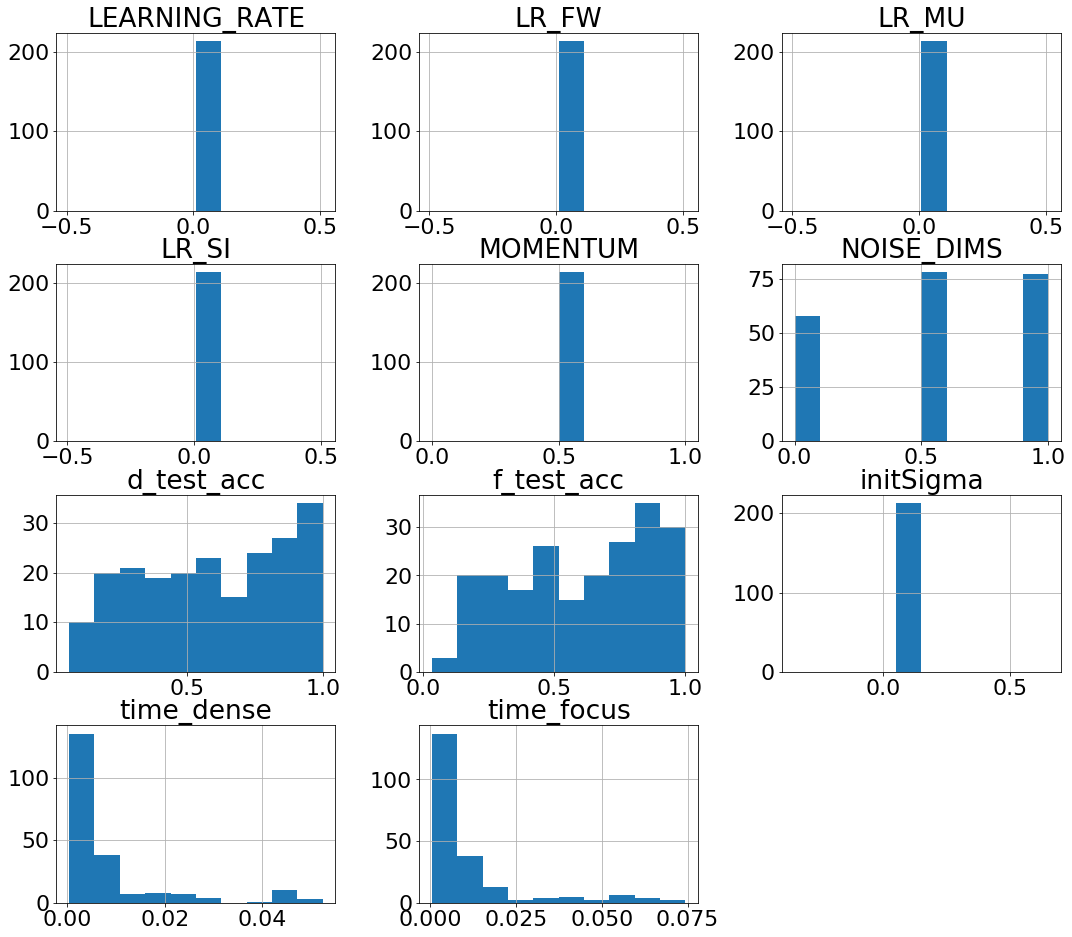

In [39]:
#@markdown - Plot distributions for columns

df.hist(figsize=(18,16))

In [13]:
#@markdown - See stats. compare mean f_test_acc vs d_test_acc
#@markdown - See stats. compare mean time_focus vs time_dense per epoch
df.describe()

,NOISE_DIMS,LEARNING_RATE,MOMENTUM,LR_MU,LR_SI,LR_FW,initSigma,f_test_acc,d_test_acc,time_dense,time_focus
count,213.000000,213.00,213.0,213.00,213.0000,213.00,2.130000e+02,213.000000,213.000000,213.000000,213.000000
mean,0.544601,0.01,0.5,0.01,0.0082,0.01,1.500000e-01,0.601332,0.587707,0.008278,0.010648
std,0.396484,0.00,0.0,0.00,0.0000,0.00,5.842402e-16,0.265205,0.267815,0.011729,0.015747
min,0.000000,0.01,0.5,0.01,0.0082,0.01,1.500000e-01,0.033333,0.066667,0.000417,0.000471
25%,0.000000,0.01,0.5,0.01,0.0082,0.01,1.500000e-01,0.360000,0.361667,0.001038,0.001300
50%,0.500000,0.01,0.5,0.01,0.0082,0.01,1.500000e-01,0.661333,0.600000,0.003627,0.004597
75%,1.000000,0.01,0.5,0.01,0.0082,0.01,1.500000e-01,0.839667,0.837667,0.010025,0.012604
max,1.000000,0.01,0.5,0.01,0.0082,0.01,1.500000e-01,1.000000,1.000000,0.052406,0.074393


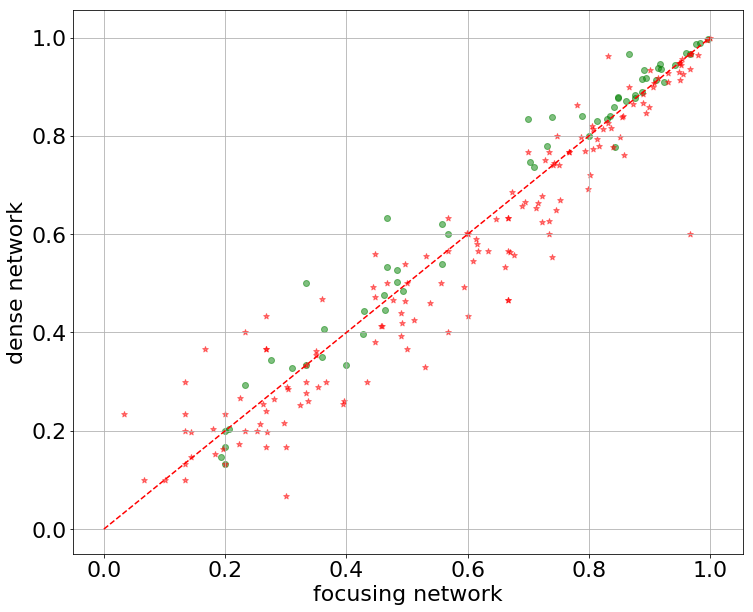

In [33]:
#@markdown ## See scatter plot here, acc of focusing network=x vs dense_network=y
plt.figure(figsize=(12,10))

noise_0 =df['NOISE_DIMS'] ==0.0
noise_1 = np.logical_or(df['NOISE_DIMS'] == 1.0, df['NOISE_DIMS'] == 0.5)
focus_acc = df['f_test_acc']
dense_acc = df['d_test_acc']
plt.scatter(focus_acc[noise_0], dense_acc[noise_0],  c='g', marker='o', cmap='jet', alpha=0.5)
plt.scatter(focus_acc[noise_1], dense_acc[noise_1],  c='r', marker='*',cmap='jet', alpha=0.5)
plt.plot([0,1.0],[0,1.0],'r--')
#plt.colorbar()
plt.xlabel('focusing network')
plt.ylabel('dense network')
plt.grid()


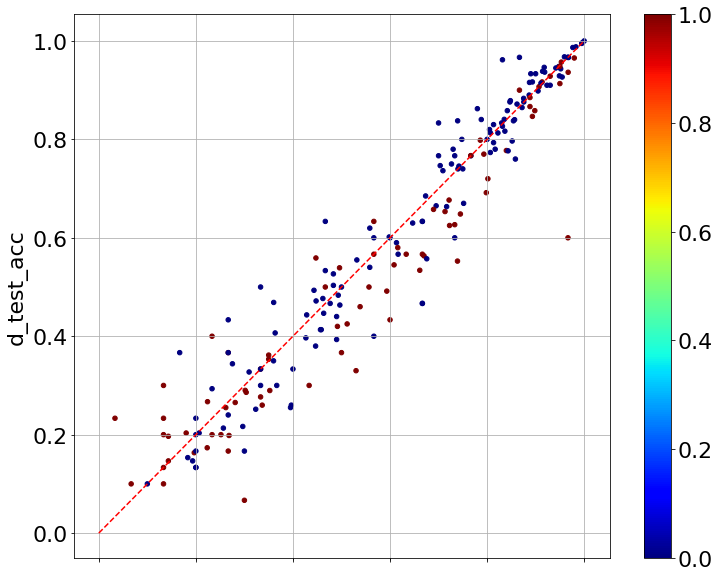

In [15]:
ax = df.plot.scatter(x='f_test_acc', y='d_test_acc',  c=df['NOISE_DIMS'].astype(int), figsize=(12,10),cmap='jet')
ax.plot([0,1.0],[0,1.0],'r--')
ax.grid()

In [16]:
df.groupby('LEARNING_RATE').mean()

,NOISE_DIMS,MOMENTUM,LR_MU,LR_SI,LR_FW,initSigma,f_test_acc,d_test_acc,time_dense,time_focus
LEARNING_RATE,,,,,,,,,,
0.01,0.544601,0.5,0.01,0.0082,0.01,0.15,0.601332,0.587707,0.008278,0.010648


         NOISE_DIMS  LEARNING_RATE  ...  time_dense  time_focus
nHIDDEN                             ...                        
4          0.639706           0.01  ...    0.003504    0.004300
40         0.484375           0.01  ...    0.008355    0.010702
100        0.512346           0.01  ...    0.012224    0.015934

[3 rows x 11 columns]


Text(0.5, 0, 'Num hidden')

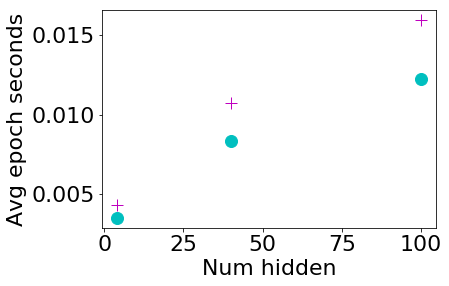

In [17]:

grp_nhidd= df.groupby('nHIDDEN').mean()
print(grp_nhidd)
plt.plot(grp_nhidd['time_dense'],'co',markersize=12)
plt.plot(grp_nhidd['time_focus'],'m+', markersize=12)
plt.ylabel('Avg epoch seconds')
plt.xlabel('Num hidden')

          NOISE_DIMS  LEARNING_RATE  ...  time_dense  time_focus
nSAMPLES                             ...                        
100         0.587719           0.01  ...    0.000616    0.000789
1000        0.420000           0.01  ...    0.003244    0.003927
2000        0.666667           0.01  ...    0.006059    0.007644
10000       0.490385           0.01  ...    0.023821    0.031036

[4 rows x 11 columns]


Text(0.5, 0, 'Samples')

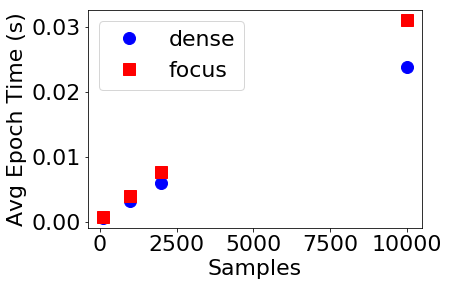

In [18]:
#lets plot time difference
#@markdown ## Epoch Time difference for different number of input samples 
grp_nsamp = df.groupby('nSAMPLES').mean()
print(grp_nsamp)
plt.plot(grp_nsamp['time_dense'],'bo', markersize=12)
plt.plot(grp_nsamp['time_focus'],'rs', markersize=12)
plt.legend(['dense','focus'])
plt.ylabel('Avg Epoch Time (s)')
plt.xlabel('Samples')


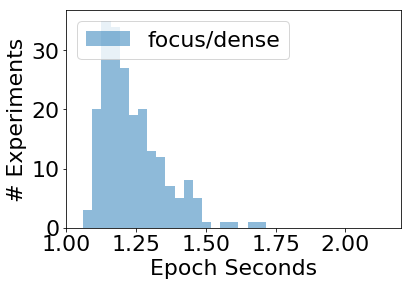

In [38]:
#@markdown ## Distribution of Epoch Time ratio for different number of input samples 
#@markdown If we inspect this one with previous plot. We observe that focusing neuron is ~*1*.2 slower than dense neuron
t_dense = df['time_dense']
t_focus = df['time_focus']
plt.hist(t_focus/t_dense, bins=20, alpha=0.5)
plt.xlabel('Epoch Seconds')
plt.ylabel('# Experiments')
plt.xlim([1.0,2.2])
plt.legend(['focus/dense'], loc=2)


In [20]:
df.groupby('NOISE_PATTERN').mean()

,NOISE_DIMS,LEARNING_RATE,MOMENTUM,LR_MU,LR_SI,LR_FW,initSigma,f_test_acc,d_test_acc,time_dense,time_focus
NOISE_PATTERN,,,,,,,,,,,
left,0.582569,0.01,0.5,0.01,0.0082,0.01,0.15,0.617520,0.607303,0.007943,0.010186
sides,0.504808,0.01,0.5,0.01,0.0082,0.01,0.15,0.584365,0.567170,0.008629,0.011132


In [21]:
df.groupby('NOISE_DIMS').mean()

,LEARNING_RATE,MOMENTUM,LR_MU,LR_SI,LR_FW,initSigma,f_test_acc,d_test_acc,time_dense,time_focus
NOISE_DIMS,,,,,,,,,,
0.0,0.01,0.5,0.01,0.0082,0.01,0.15,0.654121,0.675149,0.008922,0.010985
0.5,0.01,0.5,0.01,0.0082,0.01,0.15,0.631897,0.611915,0.007122,0.009214
1.0,0.01,0.5,0.01,0.0082,0.01,0.15,0.530606,0.497320,0.008964,0.011846


Ttest_indResult(statistic=-0.4276027120886521, pvalue=0.6697470315716141)

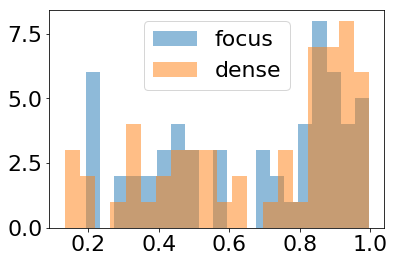

In [22]:
#@markdown ## Statistical comparison: T-tests
from scipy.stats import ttest_ind
f_acc_noise_0 = df[df['NOISE_DIMS']==0.0].f_test_acc
d_acc_noise_0 = df[df['NOISE_DIMS']==0.0].d_test_acc
plt.hist(f_acc_noise_0, bins=20, alpha=0.5)
plt.hist(d_acc_noise_0, bins=20,alpha=0.5)
plt.legend(('focus','dense'))
           
ttest_ind(f_acc_noise_0,d_acc_noise_0,equal_var=True)

#from scipy import stats
#stats.ks_2samp(f_acc_noise_0, d_acc_noise_0)

From above we can not conclude if one is better than the other. Because we test so many conditions, and the distributions does not seem normal. ks_2samp does not work better. 

So I have calculated the difference between accuracies. For both noisy and non-noisy sets. 

In [0]:
f_acc_noise_0 = df[df['NOISE_DIMS']==0.0].f_test_acc
d_acc_noise_0 = df[df['NOISE_DIMS']==0.0].d_test_acc
f_acc_noise_1 = df[df['NOISE_DIMS']==1.0].f_test_acc
d_acc_noise_1 = df[df['NOISE_DIMS']==1.0].d_test_acc

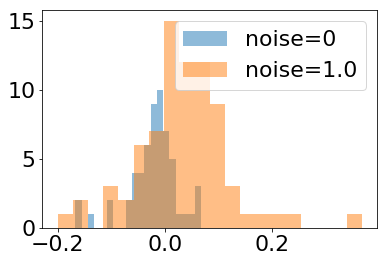

In [25]:
plt.hist(f_acc_noise_0-d_acc_noise_0,bins=20, alpha =0.5)
plt.hist(f_acc_noise_1-d_acc_noise_1,bins=20, alpha =0.5)
plt.legend(['noise=0', 'noise=1.0'])

Now this looks normal. So lets try if these differences are significant. 

In [26]:
print(ttest_ind(f_acc_noise_0-d_acc_noise_0,f_acc_noise_1-d_acc_noise_1,equal_var=True))
print("Mean noise 0:",np.mean(f_acc_noise_0-d_acc_noise_0), "Mean noise 1.0",np.mean(f_acc_noise_1-d_acc_noise_1))

Ttest_indResult(statistic=-4.317581484949873, pvalue=3.058874362932425e-05)
Mean noise 0: -0.021028735632183906 Mean noise 1.0 0.03328571428571428


We reject the null hypothesis. Accuracy difference between focusing network 
and dense network is significantly different from noisy and clean datasets. 
In summary, focusing network performs better in noisy datasets, and performs similar in clean datasets.